<a href="https://colab.research.google.com/github/yonatanlou/study_projects/blob/main/Statistics_lab/labs/Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Lab 4

Eitan.zimmerman, Matan.polke, Yonatan.lourie

In [1]:
# Import modules 
import numpy as np
import pandas as pd 
import statsmodels.api as sm 
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from functools import partialmethod

pd.DataFrame.head = partialmethod(pd.DataFrame.head, n=10)

import random
random.seed(42)


pd.get_option("display.max_columns")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


0

In [2]:
parties_dict ={'אמת': 'עבודה',
 'ב': 'ימינה',
 'ג': 'יהדות התורה',
 'ודעם': 'הרשימה המשותפת',
 'ט': 'הציונות הדתית',
 'כן': 'כחול לבן',
 'ל': 'ישראל ביתנו',
 'מחל': 'הליכוד',
 'מרצ': 'מרצ',
 'עם': 'רעם',
 'פה': 'יש עתיד',
 'שס': 'שס',
 'ת': 'תקוה חדשה'}
##relevant 13 parties

In [3]:
data_url = "https://raw.githubusercontent.com/yonatanlou/study_projects/main/Statistics_lab/votes_per_ballot_2021.csv"
votes_per_ballot = pd.read_csv(data_url,  encoding = 'iso-8859-8', index_col='שם ישוב')

df = votes_per_ballot
df = df.iloc[:,:-1]
# df.head()

Data cleaning

In [4]:
df = df.loc[~df.index.str.fullmatch('מעטפות חיצוניות')]
col_index = [6]+list(range(10,df.shape[1]))
df_model = df.iloc[:,col_index]
# df_model.info()

### 1. 

#### 1. Estimate of $\beta_j^{-1}$

We will use:
$\sum_{i=1}^{C}(\sum_{j=1}^{K}n_{ij}\beta_j^{-1}- \widetilde{n}_{j\cdot})^2$


and for the estimators for $ \widetilde{n}_{ij}$ and $\hat{q_j}$

By: $\widetilde{n}_{ij}=n_{ij}\hat{\beta}^{-1}$

And then $\hat{q_j}=\frac{\sum_{i=1}^{C}n_{ij}\hat{\beta_j}^{-1}} {\sum_{i=1}^{C}\sum_{j{}'=1}^{K}n_{ij{}'}\hat{\beta_j{}'}^{-1}}$

In [5]:
def OLS_Q1(df, votes_ratio):
    probs = df.sum().div(df.sum().sum())  #probs by party
    bzb = df.sum(axis=1)/votes_ratio #bzb ratio by party
    print(df)
    model = sm.OLS(bzb, df).fit()
    q_hat = probs * model.params 
    q_hat = q_hat / q_hat.sum()

    return probs, q_hat, model.params 

### 2

In [6]:
# Compute votes share only for parties above a certain threshold 
def parties_votes_percents(df, thresh):
    par = df.sum().div(df.sum().sum()).sort_values(ascending=False)
    return par[par > thresh]

total_votes = parties_votes_percents(df.iloc[:,10:], 0.0325)  # total votes for each party
names = total_votes.keys()

# update the data with the 13 parties above the certain threshold
df_2021 = df[names]

In [7]:
#utils functions

def fixing_data(df, fix_param):
  #p = parties_votes_percents(df, 0) 
  q_hat = parties_votes_percents(df.div(fix_param, axis = "rows"), 0)
  return q_hat



def sim_data(N,V):
  new_df = pd.DataFrame(np.random.binomial(N,V))
  #generating the matrix when the N are how much voted for each party in each city,
  #after tikun of how much would probably vote if the bzb==ksherim
  new_df.index = df.index  
  
  # votes_ratio = new_df.sum(axis=1)/ N.sum(axis=1) #by party
  # return new_df, votes_ratio
  return new_df



def simulations_lab3(fix_param, iters, N, V):
  """
  fix_param = votes/bzb matrix
  iters = how many iterations
  N = round((bzb/ksherim)*(each city,party))
  V = same as fix_param but in matrix
  """
  p_mat = np.zeros([iters, len(names)])
  q_hat = np.zeros([iters, len(names)])
  q_hat_mat = np.zeros([iters, len(names)])
  q_hat_mat2 = np.zeros([iters, len(names)])

  for i in range(0,iters):
    tmp_df = sim_data(N,V)
    q_hat[i,] = fixing_data(tmp_df, fix_param)
    p_mat[i,], q_hat_mat[i,] = OLS_Q1(tmp_df, fix_param)[0:2]

  return p_mat, q_hat, q_hat_mat



In [8]:
# N~ij :
N_tilde = np.array(df_2021.mul(df['בזב'].sum()).div(df['כשרים'].sum()),dtype='int32')
# 3 types of Vi 
alpha = df['כשרים'].div(df['בזב'])
beta = [0.6,0.65,0.75,0.5,0.4,0.35,0.8,0.55,0.45,0.25,0.3,0.7,0.2]  # arbitrary ordering
beta_rndm = random.sample(beta, len(beta))

dim = df_2021.shape
# converting them to the desired shape:
V_alpha = np.tile(np.array([alpha]).transpose(), (1, len(names)))
V_beta = np.tile(np.array(beta), (dim[0],1))
V_beta_rndm = np.tile(np.array(beta_rndm), (dim[0],1))


In [9]:
iters = 1 # number of simulations
q_real = N_tilde.sum(axis=0)/(N_tilde.sum())
sim_alpha = simulations_lab3(alpha, iters, N_tilde, V_alpha)
mean_p_alpha = sim_alpha[0].mean(axis=0)
mean_q_alpha = sim_alpha[1].mean(axis=0)
bias_q_alpha = mean_q_alpha - q_real
var_q_alpha = sim_alpha[1].var(axis=0)
mse_q_alpha = var_q_alpha + bias_q_alpha**2
mean_q_v_new = np.nanmean(sim_alpha[2],axis=0)

sim_beta = simulations_lab3(alpha, iters, N_tilde, V_beta)
mean_p_beta = sim_beta[0].mean(axis=0) 
mean_q_beta = sim_beta[1].mean(axis=0) 
bias_q_beta = mean_q_beta - q_real
var_q_beta = sim_beta[1].var(axis=0)
mse_q_beta = var_q_beta + bias_q_beta**2
mean_q_beta_new = sim_beta[2].mean(axis=0)

sim_beta_rndm = simulations_lab3(alpha, iters, N_tilde, V_beta_rndm)
mean_p_beta_rndm = sim_beta_rndm[0].mean(axis=0)
mean_q_beta_rndm = sim_beta_rndm[1].mean(axis=0)
bias_q_beta_rndm = mean_q_beta_rndm - q_real
var_q_beta_rndm = sim_beta_rndm[1].var(axis=0)
mse_q_beta_rndm = var_q_beta_rndm + bias_q_beta_rndm**2
mean_q_beta_rndm_new = np.nanmean(sim_beta_rndm[2],axis=0)


            0    1   2   3   4    5   6   7   8   9   10   11  12
שם ישוב                                                          
אבירים       5   27   1  16   0   58   0   2   2   2   6   37   0
אדירים     104    2  70   3   6    0  10   0   0  13   6    0   0
אושה        29  100   0  45   0   86   8   9   3   0  21   28   0
אחווה       31   53   3  47   0   19   5   2   0   4   9   11   0
איבים        8    0   0   2   0    0   3   0   0   3   0    0   0
...        ...  ...  ..  ..  ..  ...  ..  ..  ..  ..  ..  ...  ..
קורנית      34  182   0  89   0  115  22  10   1   1  19  121   0
שורשים      40   91   0  41   0   72  22   5   1   1  29   22   0
שכניה       17  142   0  70   0  117  21  13   4   4  32   80   0
שער אפרים  220   98  23  57   1   32  50   5   0  17  22   28   0
שער אפרים  163  105  29  45   1   55  37  21   0  13  35   16   0

[12127 rows x 13 columns]
            0    1   2   3   4   5   6   7   8   9   10   11  12
שם ישוב                                           

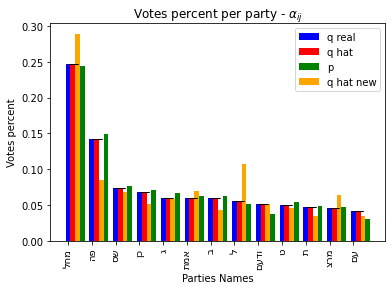

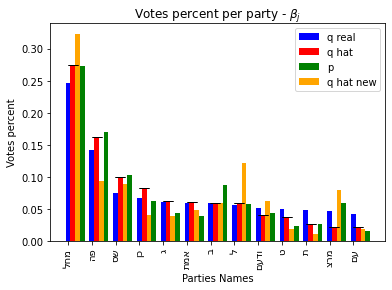

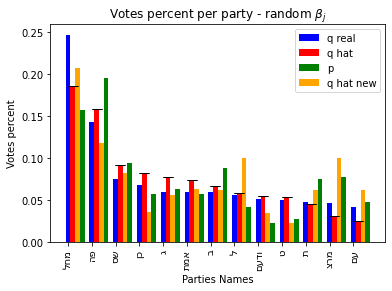

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb471596550>)

In [10]:
# Bar plot for a party, only showing values above a certain threshold after fixing:
def party_bar_fix(q_real, q_hat, p, q_hat_new, error, sim_type):
    width = 0.2  # set column width 
    n = len(total_votes)

    rev_names = [name[::-1] for name in list(names)]
    fig, ax = plt.subplots()  # plt.subplots()

    q_real_bar = ax.bar(np.arange(n), list(q_real), width, color='b')
    q_hat_bar = ax.bar(np.arange(n)+width, q_hat, width, color='r', yerr=error, capsize=5)
    p_bar = ax.bar(np.arange(n)+3*width, p, width, color='g')
    q_hat_new_bar = ax.bar(np.arange(n)+2*width, q_hat_new, width, color='orange')

    ax.set_ylabel('Votes percent')
    ax.set_xlabel('Parties Names')
    ax.set_title('Votes percent per party - ' + sim_type)
    ax.set_xticks(np.arange(n))
    ax.set_xticklabels(rev_names, rotation=90)
    ax.legend((q_real_bar, q_hat_bar, p_bar,q_hat_new_bar), ('q real', 'q hat', 'p','q hat new'))
    plt.show()

    return fig, ax

party_bar_fix(q_real, mean_q_alpha, mean_p_alpha, mean_q_v_new, np.sqrt(var_q_alpha), r'$\alpha_{ij}$')
party_bar_fix(q_real, mean_q_beta, mean_p_beta, mean_q_beta_new, np.sqrt(var_q_beta), r'$\beta_j$')
party_bar_fix(q_real, mean_q_beta_rndm, mean_p_beta_rndm, mean_q_beta_rndm_new, np.sqrt(var_q_beta_rndm), r'random $\beta_j$')

In the $\alpha$ plot we can see that new $\hat{q}$ is not that accurate. Hard to see why the innaccuracy is happening (there is parties where the estimates are great like in "ג" and "ודעם").

Its intersting to see that in the other plots, were we randomly assigned prbos with the $v$ vector, we have high correlation between the real $q$ and the new $\hat{q}$



### 3. 

In [11]:
eshkol_df = pd.read_excel("https://raw.githubusercontent.com/yonatanlou/study_projects/main/Statistics_lab/eshkol_hevrati_calcali.xlsx")
cities_data_url = "https://raw.githubusercontent.com/yonatanlou/study_projects/main/Statistical_learning_and_data%20analysis/votes_per_city_2021.csv"
cities_df = pd.read_csv(cities_data_url, encoding = 'iso-8859-8', index_col='שם ישוב').iloc[:,:-1]
# eshkol_df.set_index("set_code", inplace=True)


In [12]:
big_df = cities_df.join(eshkol_df, on="סמל ישוב")
relevant_columns = [2,6] + list(range(9,big_df.shape[1]))
big_df = big_df.iloc[:,6:big_df.shape[1]]
# big_df.head()

In [13]:
print(len(big_df.index.unique()))
print(len(big_df.dropna().index.unique()))

1215
795


We can see that we left with 1171 settelments (we lost 44).

In [14]:
#df for all the cities, and df for less cities
df_13_parties = big_df.loc[:, list(parties_dict.keys())]
df_13_parties_less_cities = big_df.dropna().loc[:, list(parties_dict.keys())]

stats_13_parties = (df_13_parties.sum()/df_13_parties.sum().sum())
stats_13_parties_less_cities = df_13_parties_less_cities.sum()/df_13_parties_less_cities.sum().sum()




df_q3 = stats_13_parties.to_frame("stats_all")
df_q3["stats_partial_data"] = stats_13_parties_less_cities.to_frame("stats")["stats"]


df_q3.reset_index(inplace=True)
df_q3['index'] = df_q3.loc[:,'index'].apply(lambda x: x[::-1])
df_q3.rename(columns={"index":"party"}, inplace=True)
df_q3["diff"] = abs(df_q3["stats_all"] - df_q3["stats_partial_data"])
df_q3.sort_values(by="diff",ascending=False)

,party,stats_all,stats_partial_data,diff
9,םע,0.038447,0.106229,0.067781
3,םעדו,0.048923,0.109437,0.060515
7,לחמ,0.245528,0.208265,0.037262
2,ג,0.057163,0.028960,0.028203
10,הפ,0.141328,0.121116,0.020212
4,ט,0.051928,0.037021,0.014907
1,ב,0.063019,0.050055,0.012963
11,סש,0.072724,0.062424,0.010300
12,ת,0.048135,0.039759,0.008376
8,צרמ,0.046537,0.052114,0.005577


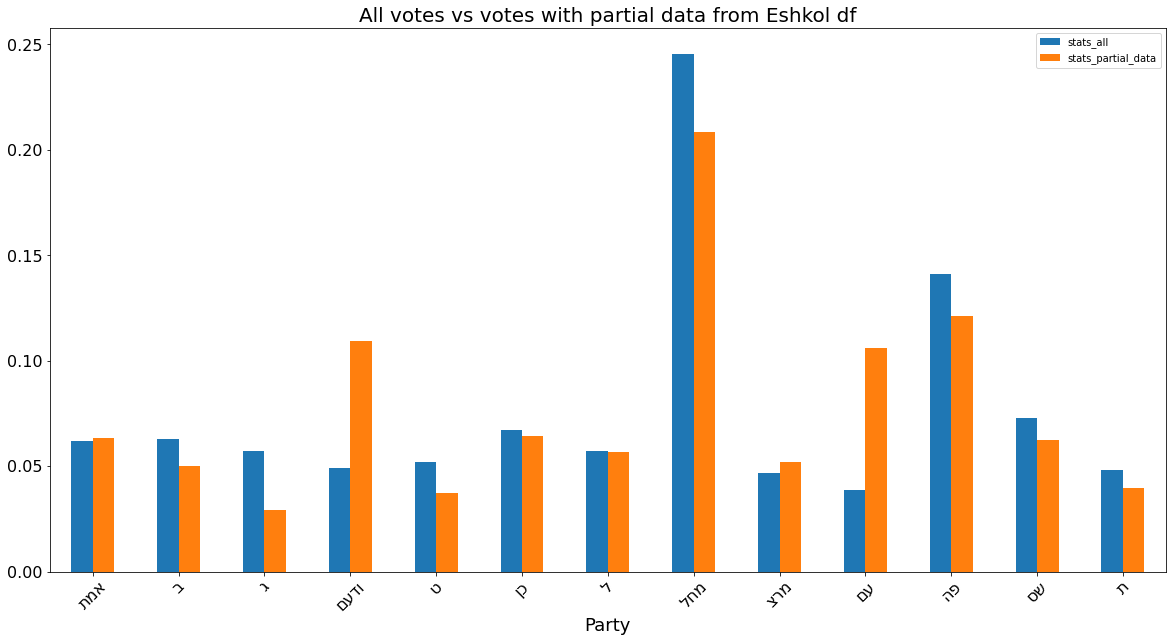

In [15]:

ax = df_q3.plot(x="party", y=["stats_all", "stats_partial_data"], kind="bar",figsize=(20,10),rot=45,
           fontsize=16)

  
  
plt.title(label="All votes vs votes with partial data from Eshkol df", fontdict={"fontsize":20})
plt.xlabel('Party', fontsize=18)
plt.legend()


In the plot above, i plot the difference before the loss of the cities without the Eshkol data, and after.
I also plotted the absolute difference between each party.
We can see the most noteble difference is in "ב", "ודעם", "אמת" and "ג".

This make sense only after we look on which places we eliminated from the original data:

**The cities that was eliminated:**

In [16]:
big_df[big_df.isna().any(axis=1)].index.unique()

Index(['אבירים', 'אלעריאן', 'אליעד', 'אמנון', 'אפיק', 'אשל הנשיא', 'אשקלון',
       'גבעולים', 'גשור', 'הר עמשא',
       ...
       'מנות', 'ענב', 'צורית', 'שבי שומרון', 'אשחר', 'הררית', 'חוסנייה',
       'נווה זיו', 'שורשים', 'מעטפות חיצוניות'],
      dtype='object', name='שם ישוב', length=420)

In [17]:
tmp = big_df[big_df.isna().any(axis=1)].iloc[:,:-4]
tmp = tmp.loc[:,list(parties_dict.keys())]
tmp.T.sum().sort_values(ascending=False)[:10]

שם ישוב
מעטפות חיצוניות    414373
תל אביב  יפו       258955
ירושלים            246188
חיפה               134489
ראשון לציון        131470
פתח תקווה          125788
נתניה              103165
חולון               94970
באר שבע             90082
רמת גן              85856
dtype: int64

We can see that most of that votes are from "מעטפות חיצוניות" (probably in relate to "אמת"), bedouin tribes (probably relate to "ודעם"),  some ״התנחלויות״ (maybe for "ב", "ג") and army bases.

### 4. 

#### 4.a

In [18]:
df_13_parties = big_df.loc[:, list(parties_dict.keys())+["eco_level"]]

In [19]:
sums = df_13_parties.groupby(by="eco_level").sum()
sums = sums.div(sums.sum(axis=1), axis=0)
sums.columns = [name[::-1] for name in  sums.columns]

<Figure size 9000x3600 with 0 Axes>

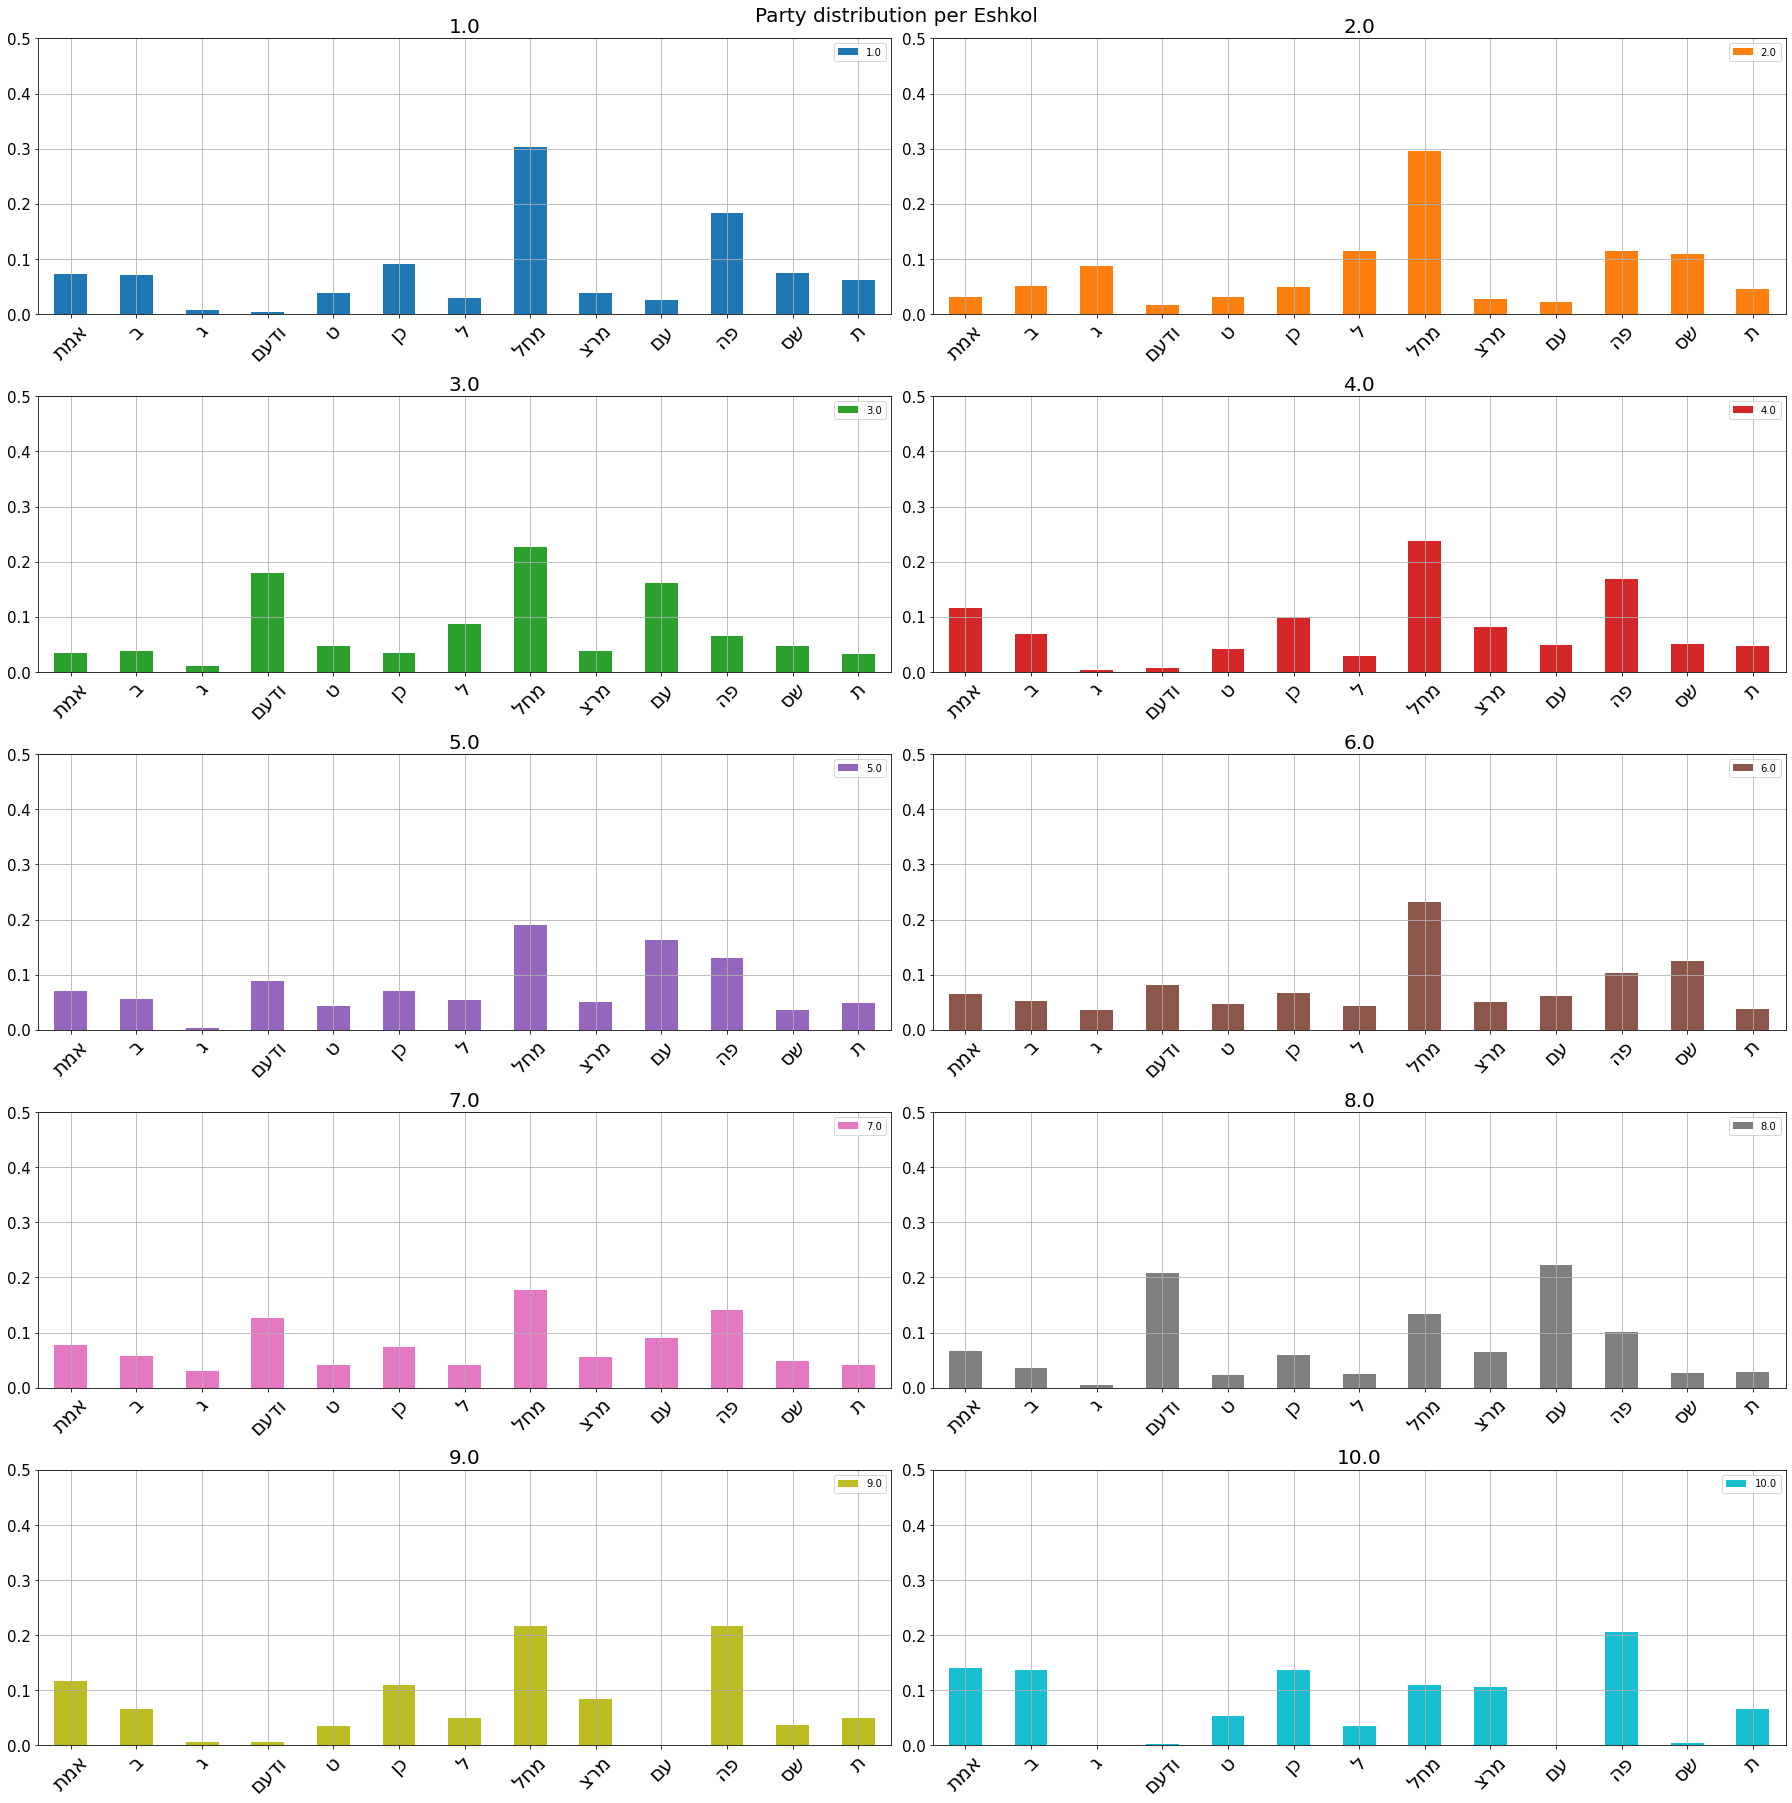

In [20]:
def plot_q4(df, layout, subplot_size, y_lim, title):
  fig = plt.figure(figsize=(25*5,25*2))

  df.plot(kind='bar', subplots=True, grid=True,
          layout=layout, sharex=False, sharey=False, legend=True,    
          style=['r', 'r', 'r', 'g', 'g', 'g', 'b', 'b', 'b', 'r', 'r', 'r'],
          figsize=subplot_size)

  for ax in plt.gcf().axes:
      ax.legend(loc=1)
      ax.xaxis.label.set_size(15)
      ax.set_ylim([0, y_lim])
      ax.tick_params(axis="x", which='major', labelsize=20,labelrotation=45)
      ax.tick_params(axis="y", which='major', labelsize=15)

      ax.title.set_size(20)



  plt.suptitle(title,y=1, fontsize=20)
  plt.tight_layout()

plot_q4(sums.T, (5,2), (25,25), 0.5, "Party distribution per Eshkol")

#### 4.b

In [21]:
sums = df_13_parties.groupby(by="eco_level").sum()
sums = sums.div(sums.sum(axis=0))
sums.columns = [name[::-1] for name in  sums.columns]

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


<Figure size 9000x3600 with 0 Axes>

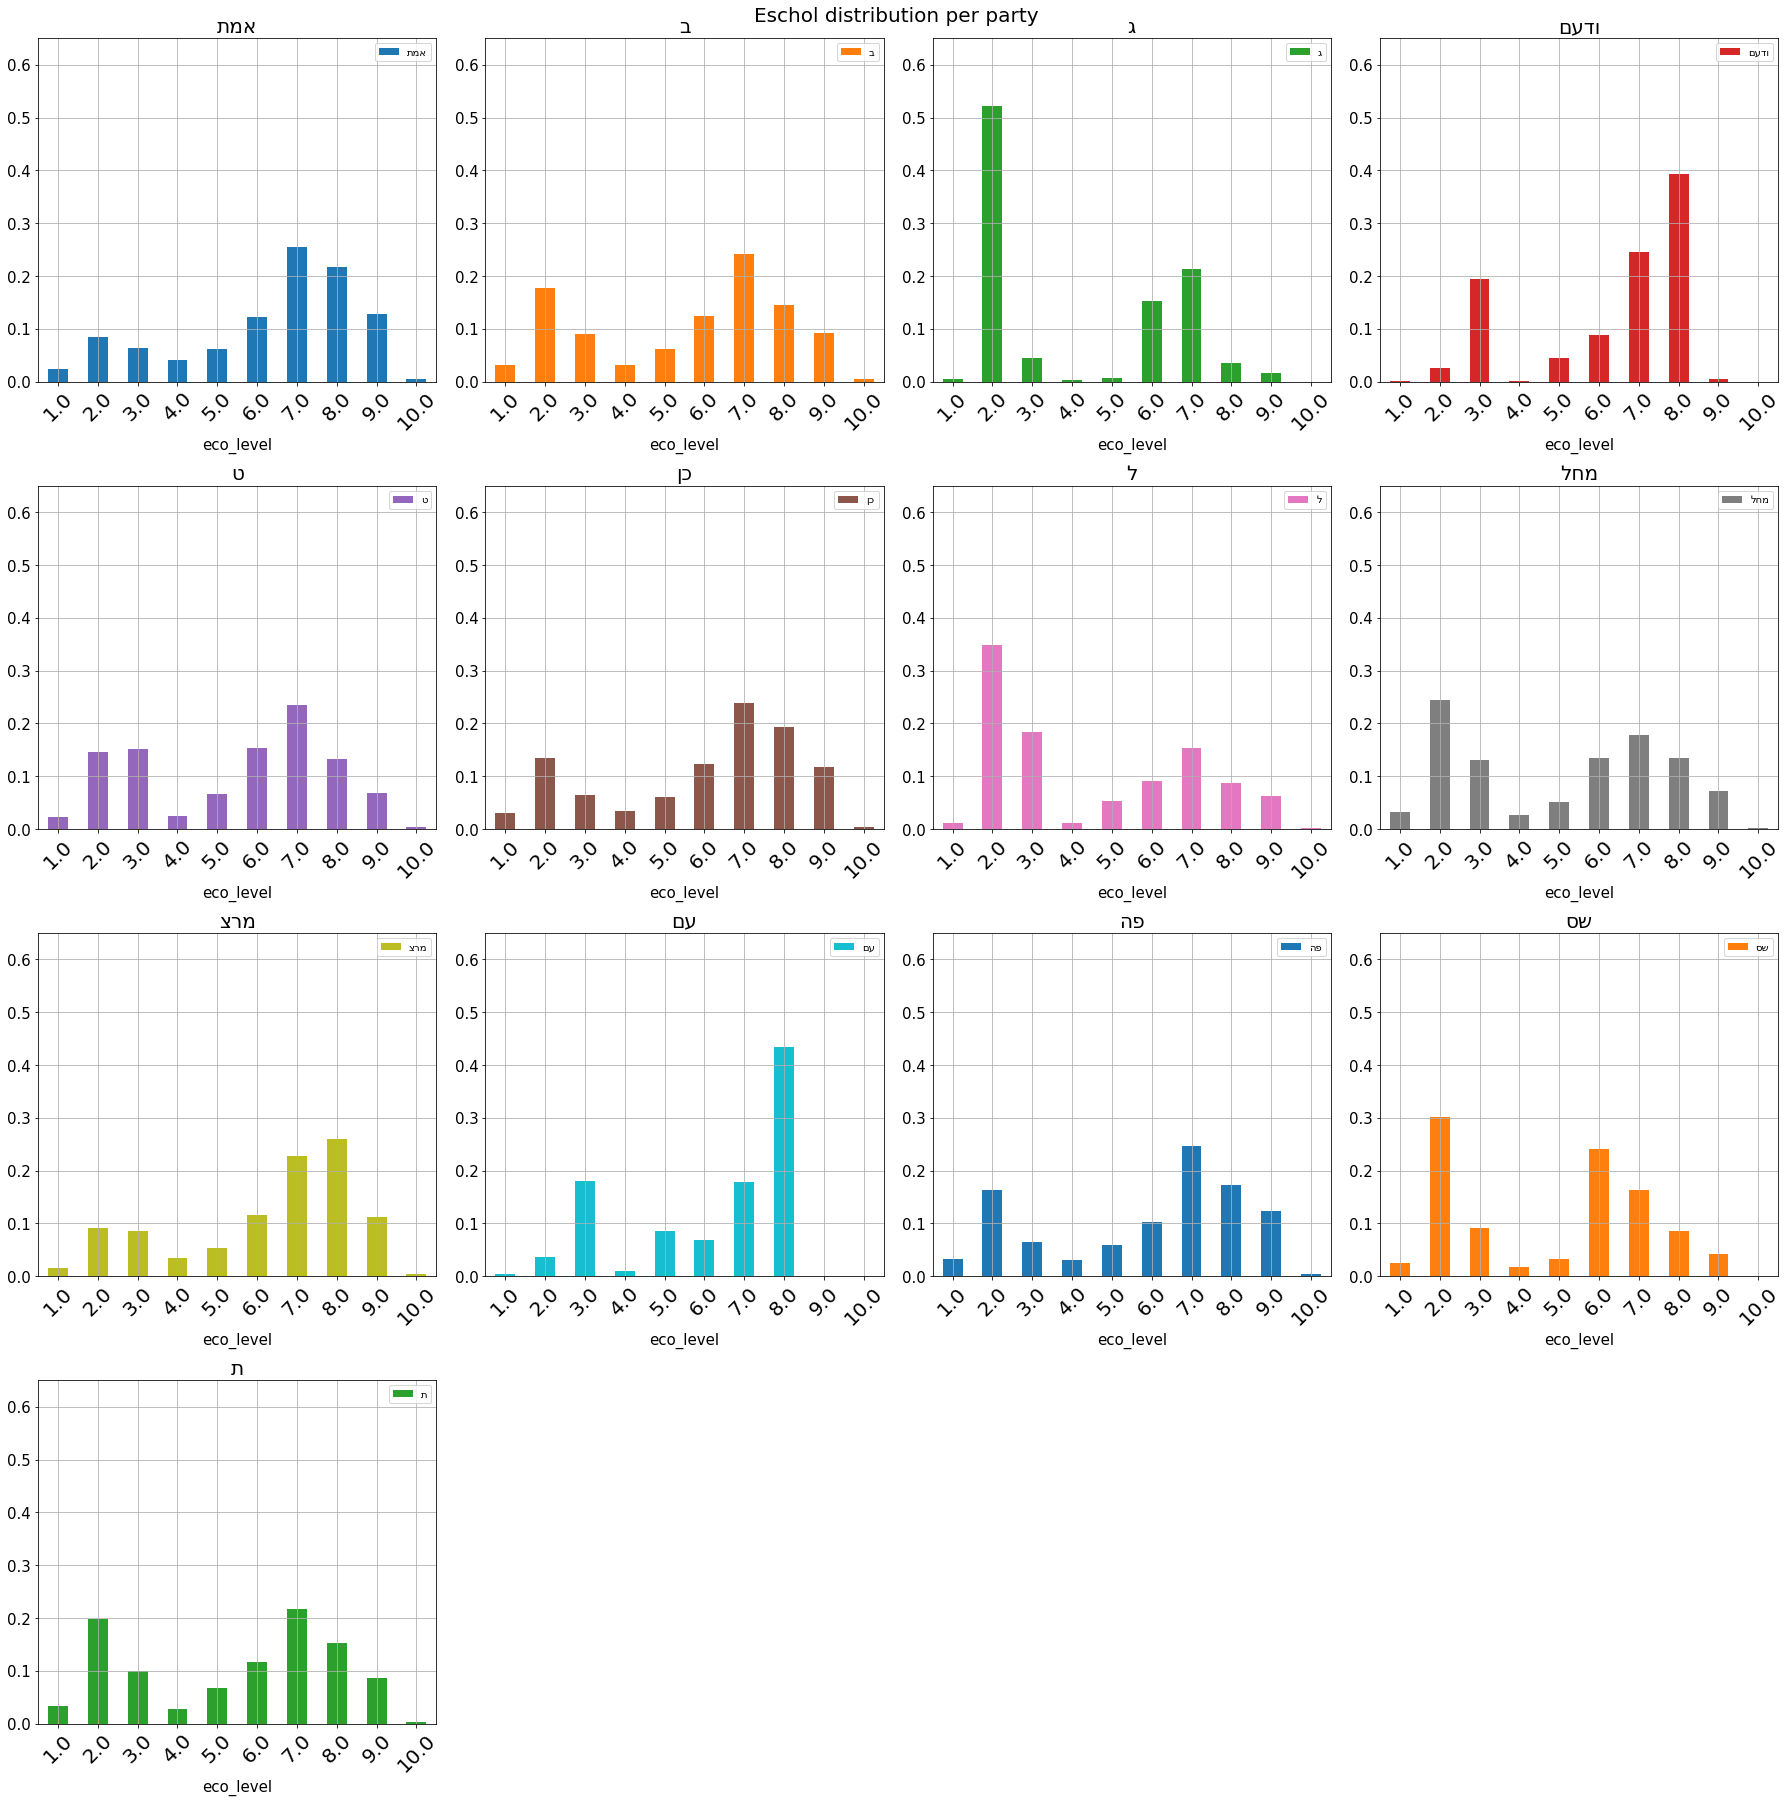

In [22]:
plot_q4(sums, (4,4), (25,25), 0.65, "Eschol distribution per party")
